# Import

In [12]:
import gymnasium as gym
import numpy as np
import torch    
from stable_baselines3 import SAC
from pendulum_env_simple import MuJoCoPendulumEnv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, lfilter_zi

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
env = MuJoCoPendulumEnv() 

Using device: cpu


In [14]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


In [15]:
def rollout_improved(model, env, n_steps=1000):
    """Rollout and collect actions from a model."""
    obs, _ = env.reset()
    actions = []
    for _ in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action[0])
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            obs, _ = env.reset()
    return np.array(actions)

# Simple SAC

In [16]:
# Create the base noisy environment (used for all rollouts)
base_env = MuJoCoPendulumEnv()
env_noisy = ActionGaussianNoiseWrapper(base_env, snr_linear=10)
# Train simple SAC on noisy env (no penalty)
model_simple = SAC(
    "MlpPolicy",
    env_noisy,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)
model_simple.learn(total_timesteps=100_000)

# Model Architectures

## High Freq Penalty

In [6]:
class HighFrequencyPenaltyWrapper(gym.Wrapper):
    """
    Penalizes action frequencies above a cutoff (default 10Hz).
    Uses a high-pass filter to extract high-frequency components and penalizes them.
    """
    def __init__(
        self,
        env,
        fs=20.0,           # sampling frequency (Hz)
        cutoff_hz=10.0,    # penalize frequencies above this
        lambda_hf=0.1,     # penalty weight for high-frequency content
    ):
        super().__init__(env)
        
        self.lambda_hf = lambda_hf
        self.fs = fs
        self.cutoff_hz = cutoff_hz
        
        # Design a high-pass Butterworth filter to detect high-frequency components
        nyq = 0.5 * fs
        normalized_cutoff = cutoff_hz / nyq
        # Clamp to valid range (0, 1) for filter design
        normalized_cutoff = min(max(normalized_cutoff, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="high")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Reset filter state
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)
        
        obs, reward, terminated, truncated, info = self.env.step(action_env)
        
        # Extract high-frequency component of the action
        u_hf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u_hf[0]
        
        # Penalize high-frequency content (squared to make it smooth and always positive)
        hf_penalty = -self.lambda_hf * u_hf**2
        
        reward += hf_penalty
        
        return obs, reward, terminated, truncated, info
    
# Wrap noisy env with LPF penalty for training
env_LPF = HighFrequencyPenaltyWrapper(env_noisy, cutoff_hz=10.0, lambda_hf=0.1)
model_LPF = SAC(
    "MlpPolicy",
    env_LPF,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)
# model_LPF.learn(total_timesteps=100_000)

## Action Rate Penalty

In [ ]:
class ActionRatePenaltyWrapper(gym.Wrapper):
    """
    Penalizes rapid action changes - a simple and effective way to reduce HF content.
    No filter design needed.
    """
    def __init__(self, env, lambda_rate=0.1):
        super().__init__(env)
        self.lambda_rate = lambda_rate
        self.prev_action = 0.0
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_action = 0.0
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Penalize rapid action changes (high frequency = rapid changes)
        rate_penalty = -self.lambda_rate * (u - self.prev_action)**2
        reward += rate_penalty
        
        self.prev_action = u
        return obs, reward, terminated, truncated, info
    
# Create training environment with action rate penalty
env_rate = ActionRatePenaltyWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    lambda_rate=0.1
)

# Train SAC model
model_rate = SAC("MlpPolicy", env_rate)
model_rate.learn(total_timesteps=100_000)
print("Action Rate Penalty model trained!")

## LPF + action penalty

In [ ]:
class CombinedPenaltyWrapper(gym.Wrapper):
    """
    Combines LPF-based HF penalty with action rate penalty for better noise attenuation.
    """
    def __init__(
        self, 
        env, 
        lambda_hf=0.3,      # HF penalty weight (increased)
        lambda_rate=0.1,    # Action rate penalty weight
        cutoff_hz=5.0,      # Lower cutoff for realistic control bandwidth
        fs=50.0             # Sampling frequency
    ):
        super().__init__(env)
        self.lambda_hf = lambda_hf
        self.lambda_rate = lambda_rate
        self.prev_action = 0.0
        
        # LPF to extract HF component via residual
        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.prev_action = 0.0
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # HF penalty via LPF residual
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]
        hf_penalty = -self.lambda_hf * u_hf**2
        
        # Action rate penalty
        rate_penalty = -self.lambda_rate * (u - self.prev_action)**2
        self.prev_action = u
        
        reward += hf_penalty + rate_penalty
        
        info['hf_penalty'] = hf_penalty
        info['rate_penalty'] = rate_penalty
        
        return obs, reward, terminated, truncated, info
    
# Create training environment with combined penalty
env_combined = CombinedPenaltyWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_hf=0.3,    # Changed from lambda_lpf to match wrapper definition
    lambda_rate=0.1
)

# Train SAC model
model_combined = SAC("MlpPolicy", env_combined, verbose=1)
model_combined.learn(total_timesteps=100_000)
print("Combined Penalty model trained!")

## DeepMind Style

In [17]:
class DMWrapper(gym.Wrapper):
    """
     DM-style with lower cutoff, stronger penalty, and better sigmoid parameters.
    """
    def __init__(
        self,
        env,
        fs=50.0,
        cutoff_hz=5.0,         # Lower cutoff
        lambda_penalty=0.5,    # Stronger penalty
        sigmoid_scale=50.0,    # Sharper transition
        energy_bias=0.005,     # Lower threshold
        energy_decay=0.9,      # Faster response
    ):
        super().__init__(env)

        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.energy_bias = energy_bias
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)

        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]

        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1 - self.energy_decay) * (u_hf ** 2)
        )

        hf_score = 1.0 / (
            1.0 + np.exp(-self.sigmoid_scale * (self.hf_energy - self.energy_bias))
        )

        reward += -self.lambda_penalty * hf_score

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "u_hf": u_hf,
        })

        return obs, reward, terminated, truncated, info
    
# Create training environment with improved DM-style
env_improved_dm = DMWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_penalty=0.5,
    sigmoid_scale=50.0,
    energy_bias=0.005,
    energy_decay=0.9
)

# Train SAC model
model_improved_dm = SAC("MlpPolicy", env_improved_dm, verbose=1)
model_improved_dm.learn(total_timesteps=100_000)
print("Improved DM-style model trained!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Improved DM-style model trained!


In [ ]:
class DLSHighFreqPenaltyWrapper(gym.Wrapper):
    """
    Deep Loop Shaping style reward:
    - Penalizes physical-state energy ABOVE 10 Hz only
    - Uses multiplicative sigmoid constraint
    """

    def __init__(
        self,
        env,
        fs=50.0,               # sampling frequency (Hz)
        cutoff_hz=10.0,        # penalize frequencies ABOVE this
        sigmoid_scale=40.0,    # sharpness of constraint
        energy_threshold=0.01, # acceptable HF energy
        energy_decay=0.95,     # EMA time constant
    ):
        super().__init__(env)

        self.sigmoid_scale = sigmoid_scale
        self.energy_threshold = energy_threshold
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)

        # High-pass filter (>10 Hz)
        self.b, self.a = butter(2, normalized_cutoff, btype="high")
        self.zi = None

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        obs, base_reward, terminated, truncated, info = self.env.step(action)

        # ---- physical state to penalize ----
        theta_dot = obs[2]   # angular velocity (Pendulum-v1 convention)

        # High-frequency component
        theta_dot_hf, self.zi = lfilter(self.b, self.a, [theta_dot], zi=self.zi)
        theta_dot_hf = theta_dot_hf[0]

        # Running HF energy
        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1.0 - self.energy_decay) * (theta_dot_hf ** 2)
        )

        # Sigmoid constraint (1 = good, 0 = bad)
        hf_score = 1.0 / (
            1.0 + np.exp(
                self.sigmoid_scale * (self.hf_energy - self.energy_threshold)
            )
        )

        # ---- DLS-style multiplicative reward ----
        reward = base_reward * hf_score

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "theta_dot_hf": theta_dot_hf,
        })

        return obs, reward, terminated, truncated, info
    
# Create training environment with DLS-style penalty
env_dls = DLSHighFreqPenaltyWrapper(
    env=ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=10.0,
    fs=50.0,  # Match actual dt=0.02
    sigmoid_scale=40.0,
    energy_threshold=0.01,
    energy_decay=0.95
)

# Train SAC model
model_dls = SAC("MlpPolicy", env_dls, verbose=1)
model_dls.learn(total_timesteps=100_000)
print("DLS High-Frequency Penalty model trained!")

# Rollout 

In [17]:
rollout_env = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)

# Rollout all models
print("Rolling out Simple SAC model...")
actions_simple = rollout_improved(model_simple, rollout_env)

print("Rolling out Action Rate Penalty model...")
actions_rate = rollout_improved(model_rate, rollout_env)

print("Rolling out Combined Penalty model...")
actions_combined = rollout_improved(model_combined, rollout_env)

print("Rolling out Improved DM-style model...")
actions_improved_dm = rollout_improved(model_improved_dm, rollout_env)

print("Rolling out DLS High-Frequency Penalty model...")
actions_dls = rollout_improved(model_dls, rollout_env)

print("All rollouts complete!")

Rolling out Simple SAC model...
Rolling out Action Rate Penalty model...
Rolling out Combined Penalty model...
Rolling out Improved DM-style model...
Rolling out DLS High-Frequency Penalty model...
All rollouts complete!


# Compare Improved Methods vs Simple SAC

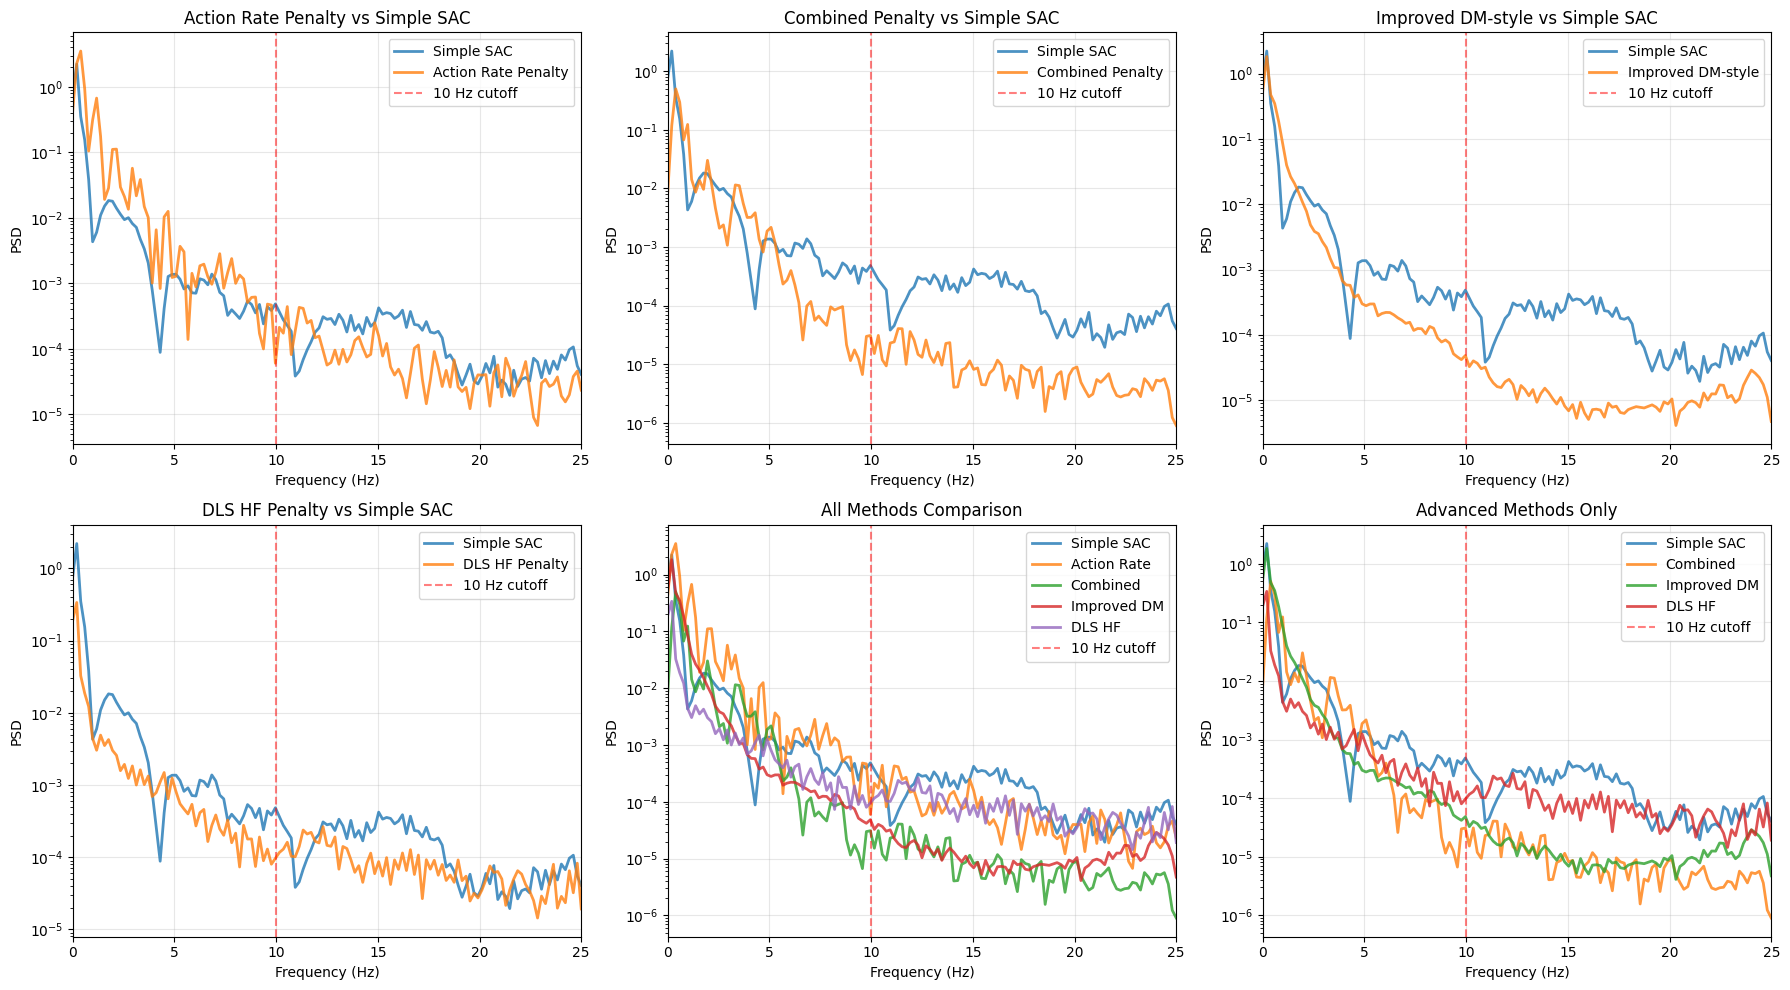


=== High-Frequency Energy (>10 Hz) as % of Total ===
Simple SAC:          0.32%
Action Rate Penalty: 0.07%
Combined Penalty:    0.06%
Improved DM-style:   0.03%
DLS HF Penalty:      0.96%


In [18]:
# Compare all improved methods against Simple SAC
from scipy.signal import welch

dt = 0.02
fs = 1 / dt  # 50 Hz

# Compute PSD for Simple SAC (reference)
freqs_simple, psd_simple = welch(actions_simple, fs=fs, nperseg=256)

# Compute PSD for improved methods
freqs_rate, psd_rate = welch(actions_rate, fs=fs, nperseg=256)
freqs_combined, psd_combined = welch(actions_combined, fs=fs, nperseg=256)
freqs_improved_dm, psd_improved_dm = welch(actions_improved_dm, fs=fs, nperseg=256)
freqs_dls, psd_dls = welch(actions_dls, fs=fs, nperseg=256)

# Plot comparison - 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top-left: Action Rate Penalty vs Simple SAC
axes[0, 0].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[0, 0].semilogy(freqs_rate, psd_rate, label='Action Rate Penalty', alpha=0.8, linewidth=2)
axes[0, 0].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('PSD')
axes[0, 0].set_title('Action Rate Penalty vs Simple SAC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 25])

# Top-middle: Combined Penalty vs Simple SAC
axes[0, 1].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[0, 1].semilogy(freqs_combined, psd_combined, label='Combined Penalty', alpha=0.8, linewidth=2)
axes[0, 1].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('PSD')
axes[0, 1].set_title('Combined Penalty vs Simple SAC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 25])

# Top-right: Improved DM-style vs Simple SAC
axes[0, 2].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[0, 2].semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM-style', alpha=0.8, linewidth=2)
axes[0, 2].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[0, 2].set_xlabel('Frequency (Hz)')
axes[0, 2].set_ylabel('PSD')
axes[0, 2].set_title('Improved DM-style vs Simple SAC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xlim([0, 25])

# Bottom-left: DLS High-Freq Penalty vs Simple SAC
axes[1, 0].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[1, 0].semilogy(freqs_dls, psd_dls, label='DLS HF Penalty', alpha=0.8, linewidth=2)
axes[1, 0].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('PSD')
axes[1, 0].set_title('DLS HF Penalty vs Simple SAC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 25])

# Bottom-middle: All improved methods together
axes[1, 1].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_rate, psd_rate, label='Action Rate', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_combined, psd_combined, label='Combined', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_dls, psd_dls, label='DLS HF', alpha=0.8, linewidth=2)
axes[1, 1].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('PSD')
axes[1, 1].set_title('All Methods Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 25])

# Bottom-right: Focus on best performing methods
axes[1, 2].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[1, 2].semilogy(freqs_combined, psd_combined, label='Combined', alpha=0.8, linewidth=2)
axes[1, 2].semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM', alpha=0.8, linewidth=2)
axes[1, 2].semilogy(freqs_dls, psd_dls, label='DLS HF', alpha=0.8, linewidth=2)
axes[1, 2].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[1, 2].set_xlabel('Frequency (Hz)')
axes[1, 2].set_ylabel('PSD')
axes[1, 2].set_title('Advanced Methods Only')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xlim([0, 25])

plt.tight_layout()
plt.savefig('all_methods_comparison.png', dpi=150)
plt.show()

# Print HF energy metrics
def compute_hf_energy(freqs, psd, cutoff=10):
    """Compute energy above cutoff frequency."""
    hf_mask = freqs > cutoff
    total = np.sum(psd)
    hf = np.sum(psd[hf_mask])
    return hf / total * 100

print("\n=== High-Frequency Energy (>10 Hz) as % of Total ===")
print(f"Simple SAC:          {compute_hf_energy(freqs_simple, psd_simple):.2f}%")
print(f"Action Rate Penalty: {compute_hf_energy(freqs_rate, psd_rate):.2f}%")
print(f"Combined Penalty:    {compute_hf_energy(freqs_combined, psd_combined):.2f}%")
print(f"Improved DM-style:   {compute_hf_energy(freqs_improved_dm, psd_improved_dm):.2f}%")
print(f"DLS HF Penalty:      {compute_hf_energy(freqs_dls, psd_dls):.2f}%")

In [19]:
# Generate Individual Comparison Plots

Generating individual comparison plots...


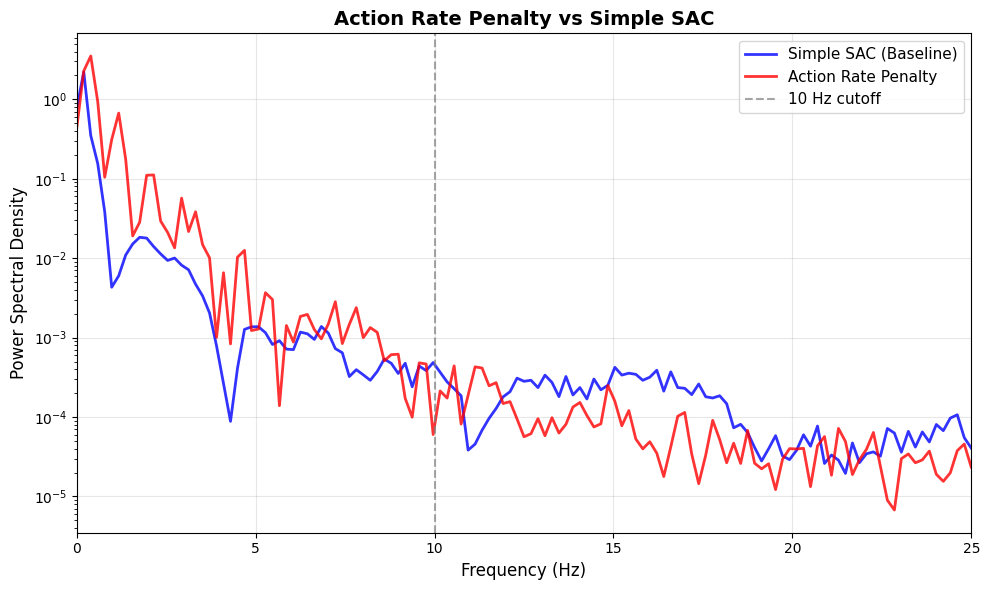

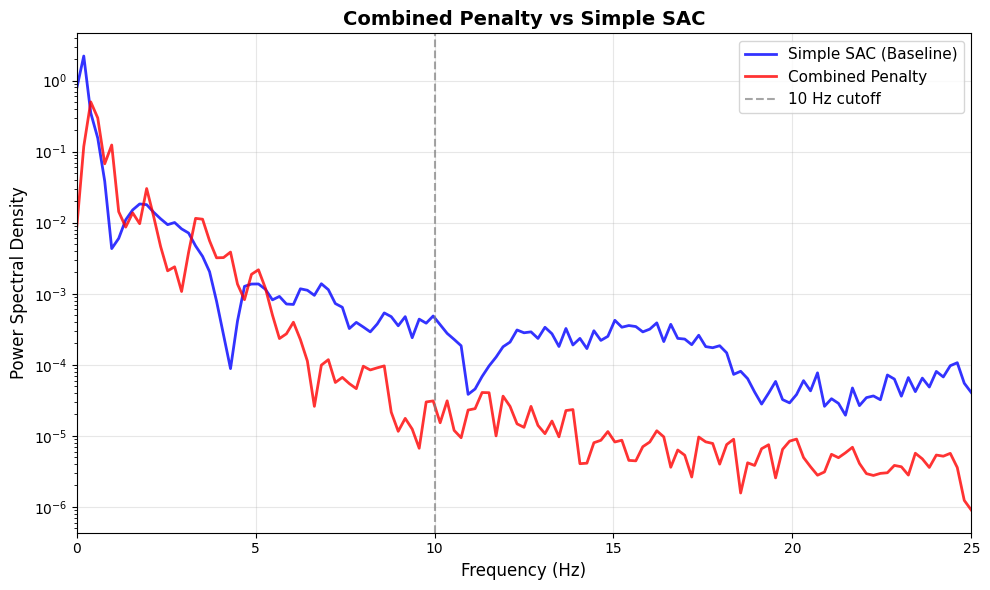

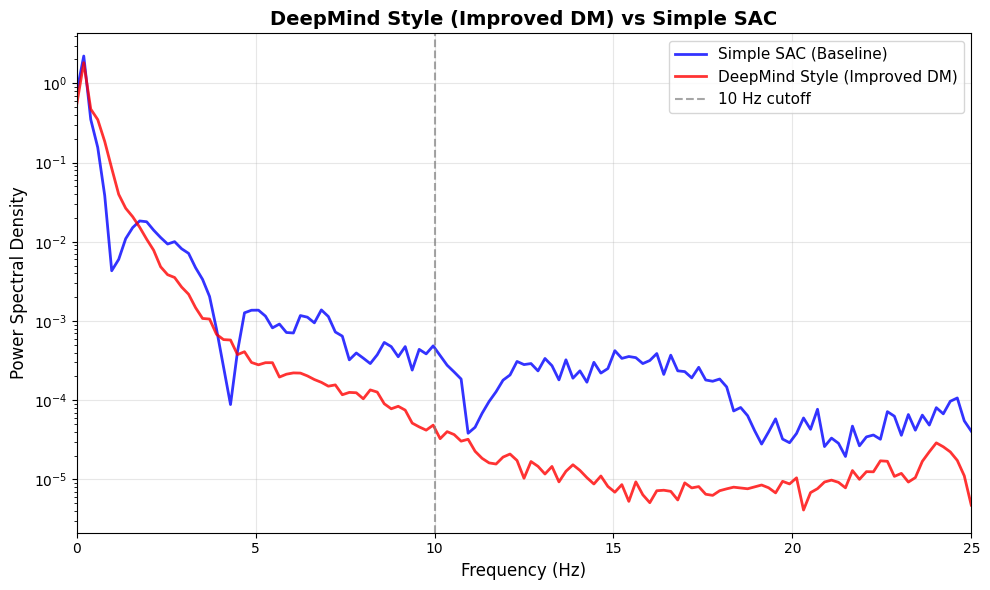

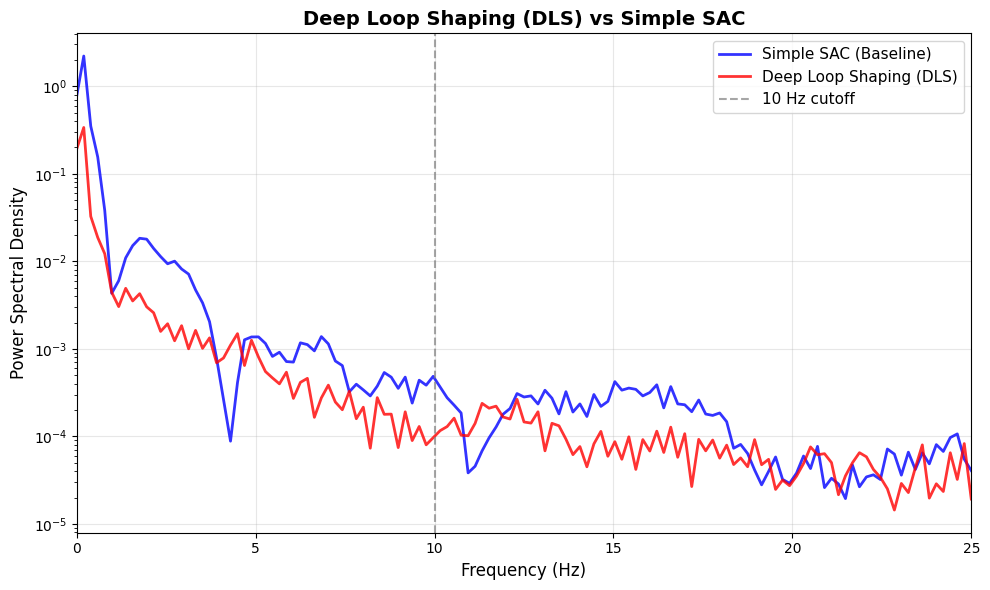

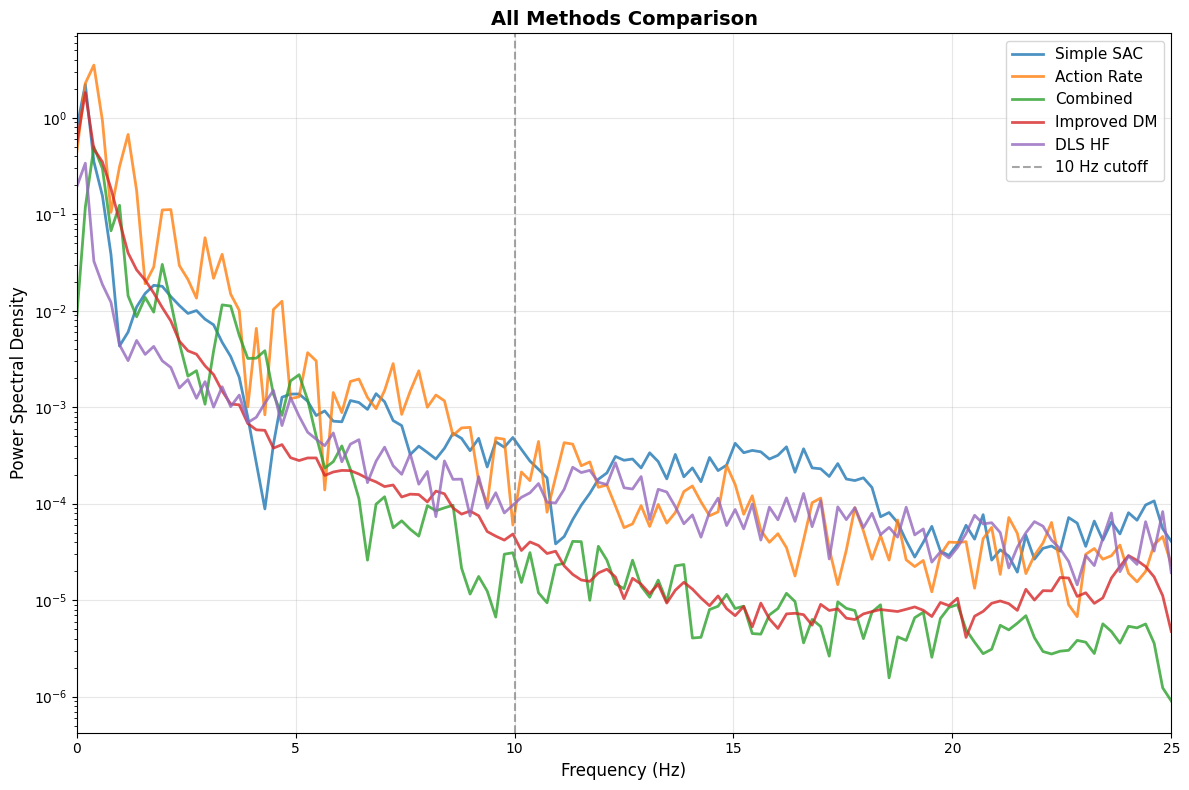


All plots saved to 'plots' directory:
- action_rate_penalty_vs_simple_sac.png
- combined_penalty_vs_simple_sac.png
- deepmind_style_vs_simple_sac.png
- dls_style_vs_simple_sac.png
- all_methods_comparison.png


In [20]:
import os

# Create plots directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# Define plotting function for individual comparisons
def plot_individual_comparison(freqs_baseline, psd_baseline, freqs_method, psd_method, 
                             method_name, filename, cutoff_hz=10):
    """Generate individual comparison plot between baseline and a specific method."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.semilogy(freqs_baseline, psd_baseline, label='Simple SAC (Baseline)', 
                alpha=0.8, linewidth=2, color='blue')
    ax.semilogy(freqs_method, psd_method, label=method_name, 
                alpha=0.8, linewidth=2, color='red')
    ax.axvline(x=cutoff_hz, color='gray', linestyle='--', alpha=0.7, label=f'{cutoff_hz} Hz cutoff')
    
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density', fontsize=12)
    ax.set_title(f'{method_name} vs Simple SAC', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 25])
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Generate individual plots for each method
print("Generating individual comparison plots...")

# 1. High Frequency Penalty (Note: this wasn't trained in the current notebook, so we'll skip it)
# 2. Action Rate Penalty
plot_individual_comparison(freqs_simple, psd_simple, freqs_rate, psd_rate, 
                         'Action Rate Penalty', 'action_rate_penalty_vs_simple_sac.png')

# 3. Combined Penalty
plot_individual_comparison(freqs_simple, psd_simple, freqs_combined, psd_combined,
                         'Combined Penalty', 'combined_penalty_vs_simple_sac.png')

# 4. DeepMind Style (Improved DM)
plot_individual_comparison(freqs_simple, psd_simple, freqs_improved_dm, psd_improved_dm,
                         'DeepMind Style (Improved DM)', 'deepmind_style_vs_simple_sac.png')

# 5. Deep Loop Shaping (DLS)
plot_individual_comparison(freqs_simple, psd_simple, freqs_dls, psd_dls,
                         'Deep Loop Shaping (DLS)', 'dls_style_vs_simple_sac.png')

# Also create a summary plot with all methods
fig_summary, ax_summary = plt.subplots(1, 1, figsize=(12, 8))
ax_summary.semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
ax_summary.semilogy(freqs_rate, psd_rate, label='Action Rate', alpha=0.8, linewidth=2)
ax_summary.semilogy(freqs_combined, psd_combined, label='Combined', alpha=0.8, linewidth=2)
ax_summary.semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM', alpha=0.8, linewidth=2)
ax_summary.semilogy(freqs_dls, psd_dls, label='DLS HF', alpha=0.8, linewidth=2)
ax_summary.axvline(x=10, color='gray', linestyle='--', alpha=0.7, label='10 Hz cutoff')
ax_summary.set_xlabel('Frequency (Hz)', fontsize=12)
ax_summary.set_ylabel('Power Spectral Density', fontsize=12)
ax_summary.set_title('All Methods Comparison', fontsize=14, fontweight='bold')
ax_summary.legend(fontsize=11)
ax_summary.grid(True, alpha=0.3)
ax_summary.set_xlim([0, 25])
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'all_methods_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll plots saved to '{plots_dir}' directory:")
print("- action_rate_penalty_vs_simple_sac.png")
print("- combined_penalty_vs_simple_sac.png") 
print("- deepmind_style_vs_simple_sac.png")
print("- dls_style_vs_simple_sac.png")
print("- all_methods_comparison.png")